# Micrograd Tutorial

Following the video [here](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=1)

This file is for the first half of the lecture, in which we implement backpropagation in a scalar value wrapper class

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

## Value Class

Data structure to keeps track of a value and the operations that led to it, maintaining a history via child nodes

In [2]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
    
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [3]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b
e.label = "e"
d = e + c
d.label = "d"
f = Value(-2.0, label="f")
L = d * f
L.label = "L"

print(a + b)
print(a * b)
print(d)
print(L)

Value(data=-1.0)
Value(data=-6.0)
Value(data=4.0)
Value(data=-8.0)


In [4]:
# Check children of d
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [5]:
# Check operation that created d
d._op

'+'

## Visualizing with GraphViz

In [6]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

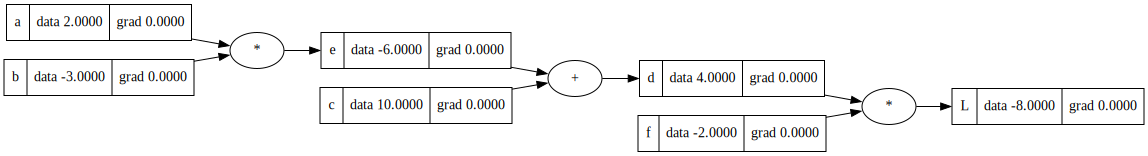

In [7]:
draw_dot(L)

## Filling in the Gradients with Backpropagation

In [8]:
def check_derivative():

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    # Perturb a value with h
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

check_derivative()

-3.9999999999995595


In [9]:
# Manually set some derivatives

# The derivative of L with respect to itself is 1
L.grad = 1.0

# The derivative of L with respect to d is f
d.grad = f.data

# The derivative of L with respect to f is d
f.grad = d.data

# The derivative of d with respect to e is 1
# (d = c + e, so 1)
# Thus the derivative of d with respect to c is also 1
# This is a "local derivative" of d (not L)

# We WANT the derivative of L with respect to c
# We can get it with the chain rule
# dL/dc = (dL/dd) * (dd/dc)

c.grad = d.grad # (* 1)
e.grad = d.grad

# NOTE: In general, an addition node will have a derivative of 1 and just distribute the upstream gradient to its children

# Find gradients for a and b
# It is a multiplication, so each uses the value of the other asb the gradient
# This is then multiplied by the upstream gradient (e)
a.grad = b.data * e.grad
b.grad = a.data * e.grad

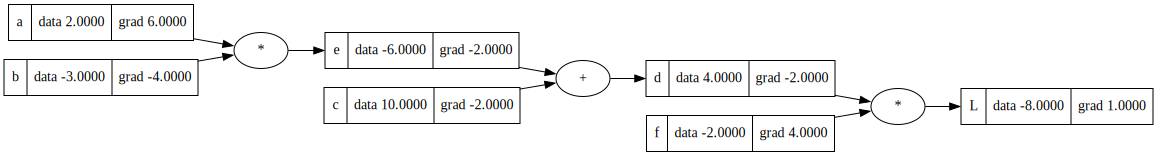

In [10]:
draw_dot(L)

## Backprop with a Neuron

In [11]:
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

# Add the bias
n = x1w1x2w2 + b
n.label = 'n'

# Output of the nueron is tanh(n)
o = n.tanh()
o.label = 'o'

### Manual Backprop

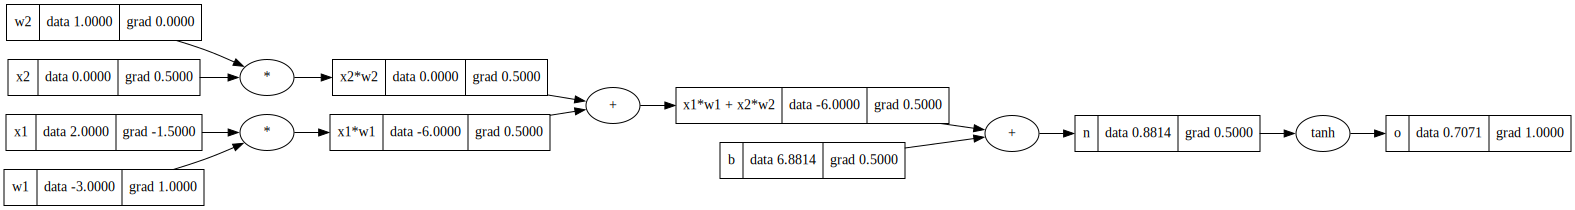

In [12]:
# Manual backpropagation
o.grad = 1.0
# The derivative of tanh(n) is (1 - tanh(n)^2)
n.grad = (1 - o.data**2)
# Next is an addition node (x1w1x2w2 + b), so just distribute the gradient
x1w1x2w2.grad = n.grad
b.grad = n.grad
# x1w1 and x2w2 are also added together, so just distribute the gradient
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
# x1 and w1 are multiplied together, so use the other value as the gradient, and multiply by the gradient of the parent
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
# Same for x2 and w2
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
draw_dot(o)

### Backprop after Implementing backward() functions

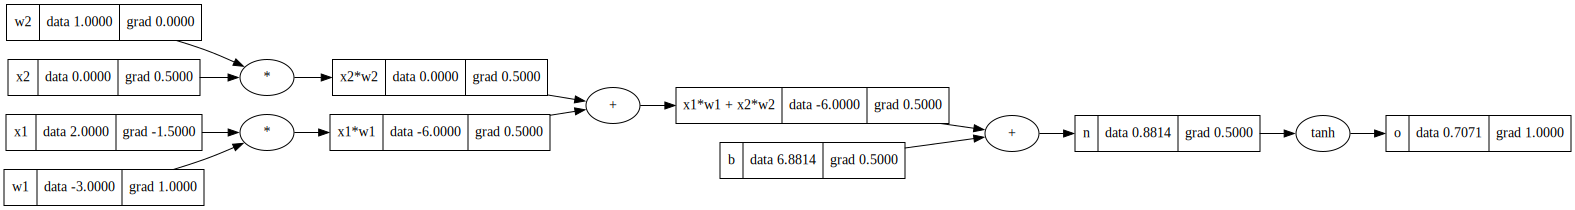

In [13]:
# Reset gradients
o.grad, n.grad, x1w1x2w2.grad, b.grad, x1w1.grad, x2w2.grad, x1.grad, w1.grad, x2.grad, w2.grad = [0.0] * 10

# Automatic backpropagation
o.grad = 1
o._backward()
n._backward()
b._backward() # lead node, so no need to call _backward on it
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
draw_dot(o)

### Automating It - Topological Sort

In [14]:
# A topological sort of the graph
# Topological sort ensures that we backpropagate in the correct order
# The parent node is only added once all children have been added
# This "lays out" the graph in a "left to right" order

topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

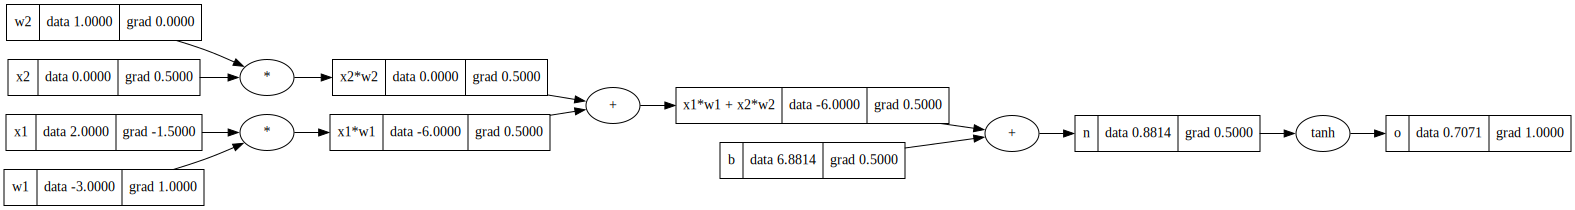

In [15]:
# Backpropagation with topological sort

# Reset gradients
o.grad, n.grad, x1w1x2w2.grad, b.grad, x1w1.grad, x2w2.grad, x1.grad, w1.grad, x2.grad, w2.grad = [0.0] * 10

# Start over find gradients

o.grad = 1
topo = []
visited = set()
build_topo(o)

for node in reversed(topo):
    node._backward()
draw_dot(o)

### Fully Automated Backprop after Implementing backward()

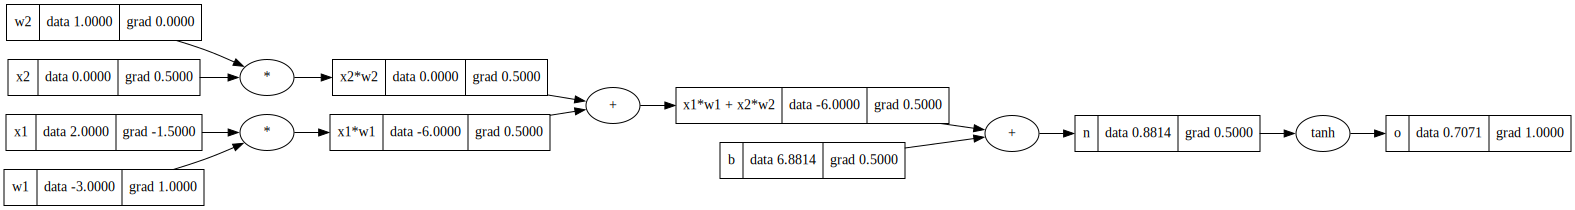

In [16]:
# Reset gradients
o.grad, n.grad, x1w1x2w2.grad, b.grad, x1w1.grad, x2w2.grad, x1.grad, w1.grad, x2.grad, w2.grad = [0.0] * 10

# Start over find gradients
o.backward()
draw_dot(o)